# CSCA 5622 Machine Learning I Final Project

**Goal**: Identify a Supervised Learning problem to perform EDA and model analysis.

[GitHub Repo](https://github.com/davidhwilliams/CSCA-5622-ML-I-Final)


# Project Focus

## CVE and CVSS Overview:

- CVEs are identifiers for security vulnerabilities.
- Each CVE has a CVSS score ranging from 0 to 10, representing the severity of the vulnerability.
- **Project goal**: Predict CVSS v3 base scores based on CVE descriptions.

## Links and Data Feeds

- https://nvd.nist.gov/vuln
- [NVD CVE API Guide](https://nvd.nist.gov/developers/vulnerabilities)
- [scikit-learn docs](https://scikit-learn.org/stable/index.html)


### 1. Data Collection

- **NVD API**:
  - Retrieved JSON data for CVEs from 2002 to 2024.
  - Parsed the data to collect CVE descriptions and CVSS v3 base scores for analysis.


### 2. Data Preprocessing

- **Preprocessing Steps**:
  - Loaded and combined CVE data into a `DataFrame`.
  - Flattened nested fields and cleaned descriptions.
  - Removed unnecessary metadata and filtered records with missing CVSS v3 scores.
  - Cleaned the description text by removing punctuation, converting to lowercase, and removing stopwords.
  - Saved cleaned data into JSON files for future use.


In [2]:
import json
import pandas as pd
import os

# Get the current working directory (location of the Jupyter Notebook)
notebook_dir = os.getcwd()

# Directory containing the JSON files relative to the notebook location
data_dir = os.path.join(notebook_dir, "data")

# Loop through each file and combine the data
all_data = []
for year in range(2020, 2025):
    file_path = os.path.join(data_dir, f"nvdcve-1.1-{year}.json")
    with open(file_path, encoding="utf-8") as f:
        data = json.load(f)
        all_data.extend(data["CVE_Items"])

# Extract CVE Items
cve_items = data["CVE_Items"]



# Convert to DataFrame for easier processing
df = pd.json_normalize(cve_items)

# Flatten and drop the lang in the cve.description.description_data field
description_data = pd.json_normalize(
    cve_items,
    record_path=["cve", "description", "description_data"],
    record_prefix="description_data.",
)

# Drop the lang field from the flattened description data
description_data = description_data.drop(columns=["description_data.lang"])

# Merge the flattened description data back into the main DataFrame
df = df.merge(
    description_data[["description_data.value"]],
    left_index=True,
    right_index=True,
    how="left",
    suffixes=("", "_description"),
)

# Drop the original nested description_data field
df = df.drop(columns=["cve.description.description_data"])

# Drop unnecessary columns (adjust based on the dataset)
df = df.drop(
    columns=[
        # metadata
        "cve.data_type",
        "cve.data_format",
        "cve.data_version",
        "cve.problemtype.problemtype_data",
        "cve.references.reference_data",
        "configurations.CVE_data_version",
        "configurations.nodes",
    ],
)

# Drop all columns with impact.baseMetricV2
df = df[df.columns.drop(list(df.filter(regex="impact.baseMetricV2")))]

# Only keep records with CVSS v3 scores - impact.baseMetricV3.cvssV3.baseScore
df = df[df["impact.baseMetricV3.cvssV3.baseScore"].notnull()]

# Clean up the description_data.value column by removing punctuation and stopwords and converting to lowercase
df["description_data.value"] = (
    df["description_data.value"].str.replace(r"[^\w\s]", "").str.lower()
)
# Remove stopwords from stopwords.txt
with open(os.path.join(data_dir, "stopwords.txt"), "r") as f:
    stopwords = f.read().splitlines()
df["description_data.value"] = df["description_data.value"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stopwords])
)

# Save the cleaned data to a JSON file and a pretty-printed JSON file
with open(
    os.path.join(data_dir, "cleaned_cve_data_pretty.json"), "w", encoding="utf-8"
) as f:
    json.dump(df.to_dict(orient="records"), f, indent=4)

df.to_json(os.path.join(data_dir, "cleaned_cve_data.json"), orient="records")

### 3. Exploratory Data Analysis (EDA)

- **Visualizing Distributions**:
  - Plotted histograms for the distribution of CVSS v3 base scores, exploitability scores, and impact scores.
- **Word Cloud**:
  - Generated a word cloud of the CVE descriptions to identify common terms.
- Identified the top 10 most frequent words in the descriptions.


Top 10 words: cross site, site scripting, plugin wordpress, disclosed public, public used, remotely disclosed, manipulation argument, authenticated attacker, including due, stored cross


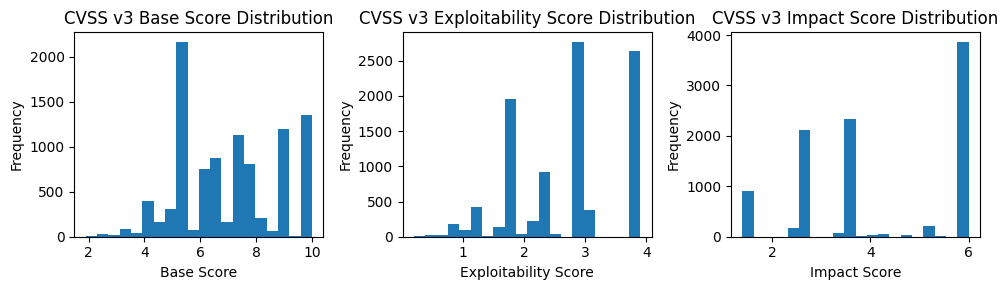

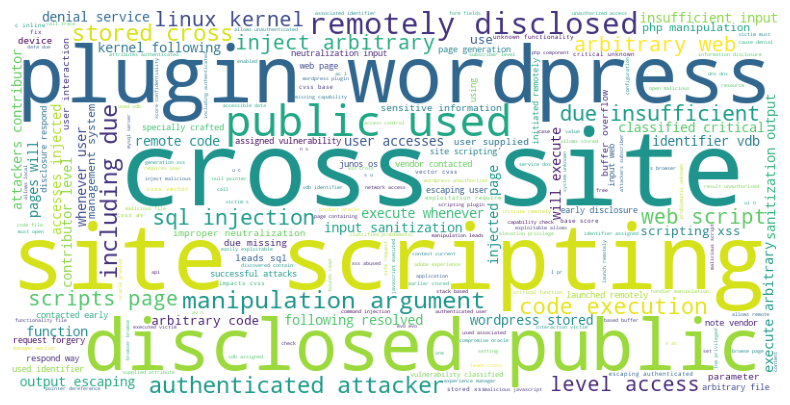

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Plot the distribution of CVSS v3 base scores, exploitability, and impact scores on a 3x1 grid
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].hist(df["impact.baseMetricV3.cvssV3.baseScore"], bins=20)
axs[0].set_title("CVSS v3 Base Score Distribution")
axs[0].set_xlabel("Base Score")
axs[0].set_ylabel("Frequency")

axs[1].hist(df["impact.baseMetricV3.exploitabilityScore"], bins=20)
axs[1].set_title("CVSS v3 Exploitability Score Distribution")
axs[1].set_xlabel("Exploitability Score")
axs[1].set_ylabel("Frequency")

axs[2].hist(df["impact.baseMetricV3.impactScore"], bins=20)
axs[2].set_title("CVSS v3 Impact Score Distribution")
axs[2].set_xlabel("Impact Score")
axs[2].set_ylabel("Frequency")

plt.tight_layout()

# Create a Word cloud of the CVE descriptions
text = " ".join(df["description_data.value"].values)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(wordcloud)

# Print the top 10 most popular words
top_words = sorted(wordcloud.words_.items(), key=lambda item: item[1], reverse=True)[
    :10
]
print("Top 10 words: " + ", ".join([word for word, _ in top_words]))

### 4. Feature Engineering

- **TF-IDF Vectorization**:
  - Converted CVE descriptions into numerical features using TF-IDF.
  - Transformed the data into a DataFrame for easier manipulation.
  - Identified the top 10 most important words based on their TF-IDF scores.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the CVE descriptions to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the CVE descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df["description_data.value"])

# Convert the TF-IDF matrix to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# Display the shape of the TF-IDF DataFrame
print(tfidf_df.shape)

# Display the top 10 most important words based on the TF-IDF scores
top_words = tfidf_df.mean().sort_values(ascending=False)[:10]
print("Top 10 words: " + ", ".join(top_words.index))

# Display the feature names (words) from the TF-IDF vectorizer
print(tfidf_vectorizer.get_feature_names_out())

(9838, 28674)
Top 10 words: user, site, code, file, plugin, cross, access, remote, arbitrary, scripting
['00' '000' '0000' ... 'zyxel' 'zzcms' 'zzz']


### 5. Model Selection and Training

- **Training a Base Model**:
  - Split data into training and testing sets.
  - Trained a Random Forest Regressor with default parameters.
  - Evaluated model performance using Mean Squared Error (MSE) and R-squared.


In [5]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

random_state = 42

# Split the data into training and testing sets and train a Random Forest Regressor
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_df,
    df["impact.baseMetricV3.cvssV3.baseScore"],
    test_size=0.2,
    random_state=random_state,
)

# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=30,  # Reduced number of trees to speed up training
    max_depth=10,  # Limit the depth of each tree
    min_samples_split=2,  # Increase the minimum number of samples required to split
    min_samples_leaf=1,  # Set minimum samples per leaf to avoid deep trees
    max_features=1.0,  # Default value, can be reduced to speed up training
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    random_state=random_state,
)
rf_regressor.fit(X_train, y_train)


# Evaluate the Random Forest Regressor
# Predict the CVSS v3 base scores for the test set
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 1.3869142188037304
R-squared: 0.5426053954965666


### 6. Model Tuning

- **Tuning Parameters**:
  - Used GridSearchCV to find the best hyperparameters for the Random Forest Regressor.
  - Performed 2-fold cross-validation to search through different parameter combinations.
  - Extracted the best parameters and retrained the model using the optimized settings.


In [6]:
# from sklearn.model_selection import GridSearchCV
# import time

# # Define the parameter distribution
# param_dist = {
#     "n_estimators": [50, 100, 200],
#     "max_depth": [10, 30, 50],
#     "min_samples_split": [8, 18, 28],
#     "min_samples_leaf": [3, 6, 9],
# }

# # Initialize the RandomizedSearchCV object
# print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
# search = GridSearchCV(
#     estimator=RandomForestRegressor(warm_start=True, random_state=random_state),
#     param_grid=param_dist,
#     cv=2,  # 2-fold cross-validation
#     n_jobs=-1,  # Use all available CPU cores
#     verbose=2,  # Verbosity level
# )

# # Fit the random search to the data
# search.fit(X_train, y_train)
# print(f"End time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")

# # Get the best parameters and the best estimator
# best_params = search.best_params_
# best_rf_regressor = search.best_estimator_

# print(f"Best parameters: {best_params}")
# print(f"Best estimator: {best_rf_regressor}")

### 7. Evaluating the Tuned Model

- **Performance Evaluation**:
  - Trained a Random Forest Regressor with tuned hyperparameters.
  - Calculated the MSE and R-squared for the tuned model on the test set.


In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Train a Random Forest Regressor
rf_regressor_tuned = RandomForestRegressor(
    n_estimators=100,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=1.0,
    n_jobs=-1,
    random_state=random_state,
)
rf_regressor_tuned.fit(X_train, y_train)

# Evaluate the Random Forest Regressor
y_pred_tuned = rf_regressor_tuned.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
print(f"Mean Squared Error: {mse_tuned}")
print(f"R-squared: {r2_tuned}")

Mean Squared Error: 1.0984982071347527
R-squared: 0.637722977969386


### 8. Model Interpretation

- **Model Comparison**:
  - Compared the base and tuned models using R-squared and MSE.
  - Examined feature importance for both models.
- **Visualization**:
  - Displayed a confusion matrix to compare actual vs. predicted CVSS v3 base scores.
  - Created scatter plots to visualize the relationship between actual and predicted scores.
  - Plotted the top 20 most important features from the Random Forest model.


R^2: 0.5426 => 0.6377
MSE: 1.3869 => 1.0985
Top features:
0: injection, injection
1: scripting, scripting
2: critical, critical
3: execution, code
4: code, execution
5: overflow, overflow
6: privilege, privilege
7: unauthorized, authentication
8: corruption, including
9: including, information


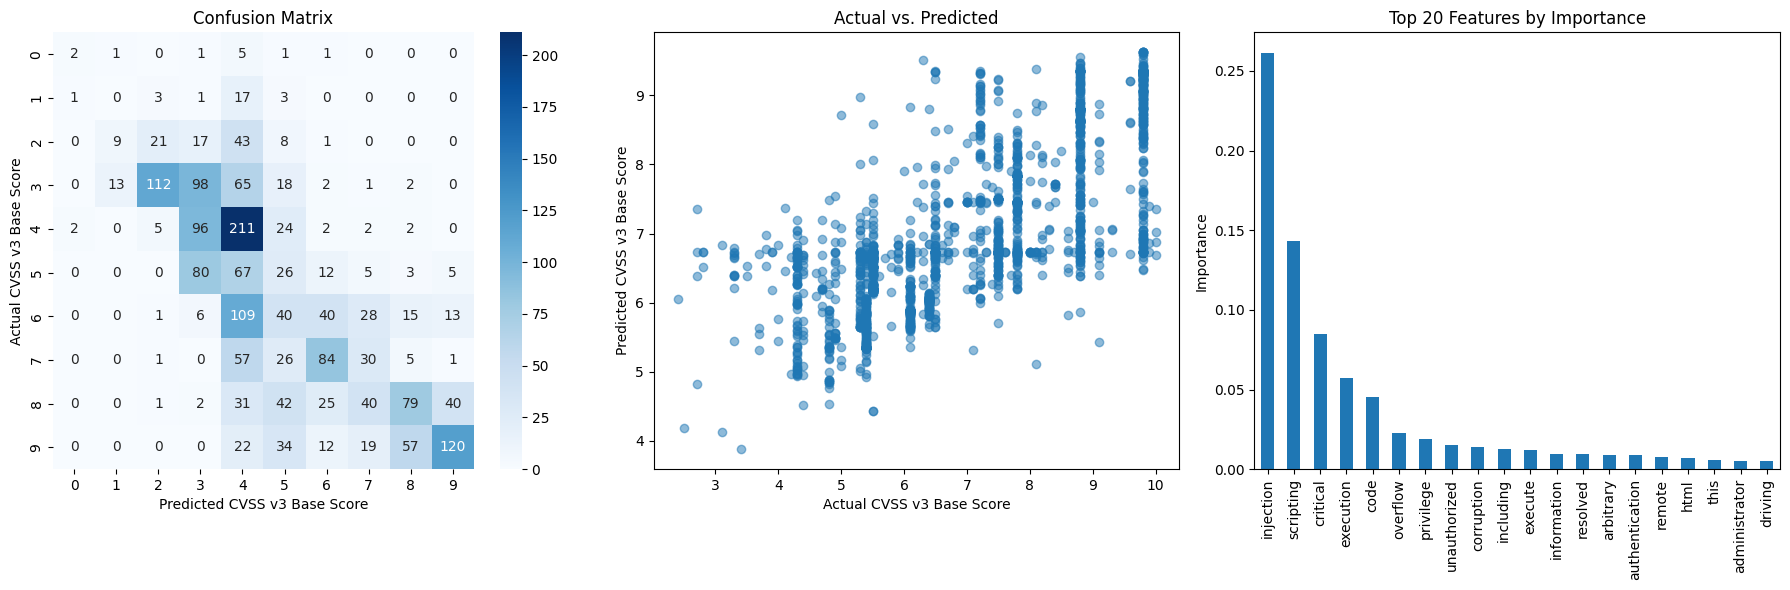

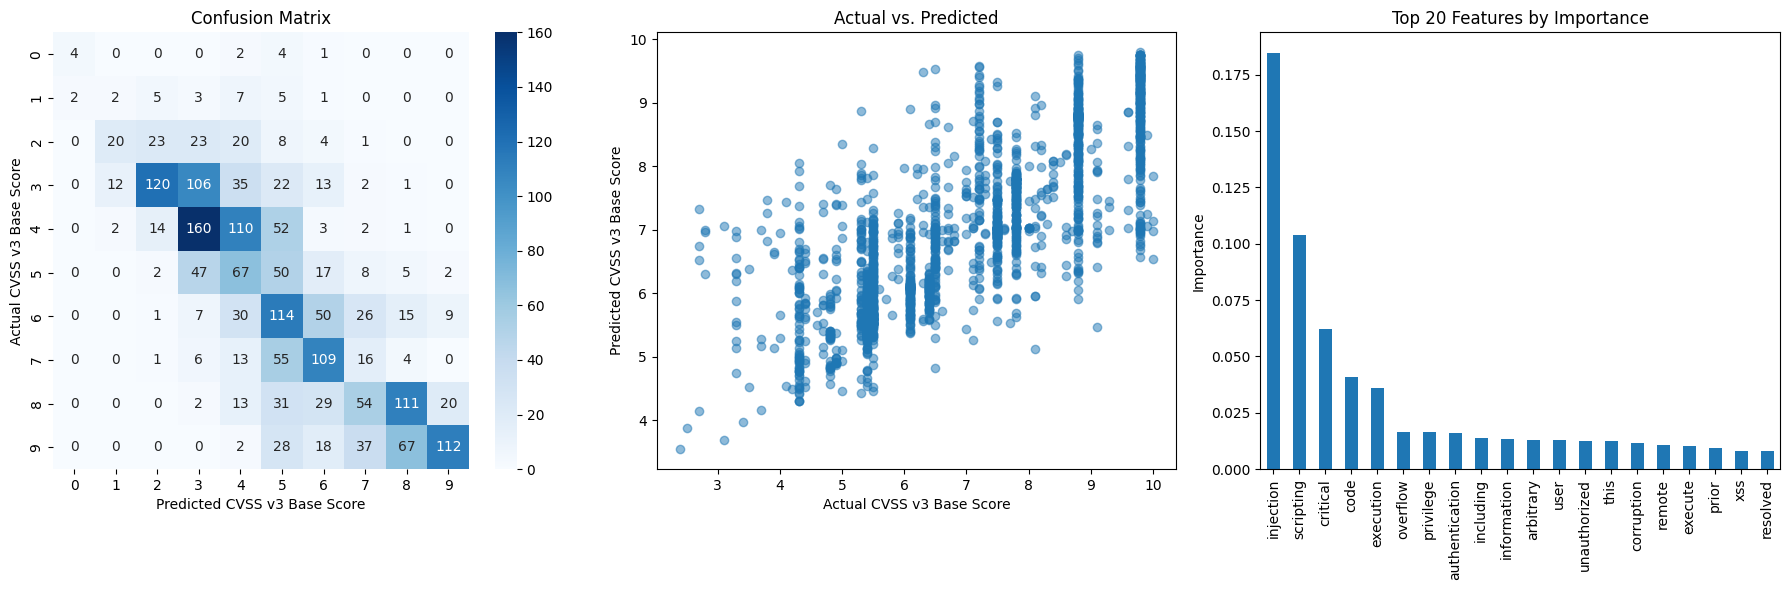

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compare base model and tuned model
print(f"R^2: {r2:.4f} => {r2_tuned:.4f}")
print(f"MSE: {mse:.4f} => {mse_tuned:.4f}")

# Compare top features
top_features = pd.Series(rf_regressor.feature_importances_, index=tfidf_df.columns).sort_values(ascending=False)
top_features_tuned = pd.Series(rf_regressor_tuned.feature_importances_, index=tfidf_df.columns).sort_values(ascending=False)

print("Top features:")
for i in range(10):
    print(f"{i}: {top_features.index[i]}, {top_features_tuned.index[i]}")

# Plot the Confusion Matrix, Actual vs. Predicted, and Feature Importance in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix
y_test_discrete = pd.cut(y_test, bins=10, labels=False)
y_pred_discrete = pd.cut(y_pred, bins=10, labels=False)
cm = confusion_matrix(y_test_discrete, y_pred_discrete)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_xlabel("Predicted CVSS v3 Base Score")
axs[0].set_ylabel("Actual CVSS v3 Base Score")
axs[0].set_title("Confusion Matrix")

# Actual vs. Predicted
axs[1].scatter(y_test, y_pred, alpha=0.5)
axs[1].set_xlabel("Actual CVSS v3 Base Score")
axs[1].set_ylabel("Predicted CVSS v3 Base Score")
axs[1].set_title("Actual vs. Predicted")

# Feature Importance
feature_importance = pd.Series(
    rf_regressor.feature_importances_, index=tfidf_df.columns
).sort_values(ascending=False)
feature_importance.head(20).plot(kind="bar", ax=axs[2])
axs[2].set_title("Top 20 Features by Importance")
axs[2].set_ylabel("Importance")

plt.tight_layout()

# Plot the Confusion Matrix, Actual vs. Predicted, and Feature Importance in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix
y_test_discrete_tuned = pd.cut(y_test, bins=10, labels=False)
y_pred_discrete_tuned = pd.cut(y_pred_tuned, bins=10, labels=False)
cm = confusion_matrix(y_test_discrete_tuned, y_pred_discrete_tuned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_xlabel("Predicted CVSS v3 Base Score")
axs[0].set_ylabel("Actual CVSS v3 Base Score")
axs[0].set_title("Confusion Matrix")

# Actual vs. Predicted
axs[1].scatter(y_test, y_pred_tuned, alpha=0.5)
axs[1].set_xlabel("Actual CVSS v3 Base Score")
axs[1].set_ylabel("Predicted CVSS v3 Base Score")
axs[1].set_title("Actual vs. Predicted")

# Feature Importance
feature_importance_tuned = pd.Series(
    rf_regressor_tuned.feature_importances_, index=tfidf_df.columns
).sort_values(ascending=False)
feature_importance_tuned.head(20).plot(kind="bar", ax=axs[2])
axs[2].set_title("Top 20 Features by Importance")
axs[2].set_ylabel("Importance")

plt.tight_layout()

### 9. Model Conclusions

#### Limitations

- **Imbalanced Data**: Model struggles with extreme CVSS scores due to fewer examples in the training data.
- **Feature Over-reliance**: Over-reliance on a few key words (e.g., 'injection', 'scripting') can lead to overfitting.
- **Discretization Issues**: Discretizing continuous CVSS scores into bins introduces classification errors.
- **Computing Power**: Model was trained using only the CPU, slowing down the training and tuning process.

#### Improvements

- **More Data**: Adding more examples, especially for extreme CVSS scores, would improve model generalization.
- **Feature Engineering**: Adding more contextual features beyond TF-IDF could improve model performance.
- **Advanced Models**: Trying gradient boosting or neural networks could capture non-linear relationships better.
- **GPU-based Training**: Leveraging GPUs
